In [1]:
# Imports and libs
import os
import os.path
import pathlib

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import io
import scipy.misc
import numpy as np

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import tensorflow as tf
import tensorflow_hub as hub

from concurrent.futures import ThreadPoolExecutor

import time

tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

In [2]:
ALL_MODELS = {
    # ImageNet datasets
    'OpenImages Inception Resnet' : 'https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1',
}

In [3]:
# Load images from inputs folder
IMAGES = []
VALID_PATHS = []
running = []

# Get all valid image paths
file_path = 'inputs/colorized_stable/' # use colorized_artistic for artistic model
for image_path in os.listdir(file_path)[::10]:
    if (image_path.endswith('.jpg')):
        # Collect image as valid path
        VALID_PATHS.append(image_path)
    
# Load given image into tensor using tensorflow io
def load_valid_image(path):
    img = tf.io.read_file(file_path + path)
    img = tf.image.decode_jpeg(img, channels=3)
    print('Load image: ' + image_path)
    IMAGES.append(img);

# Parallelize execution with threadpool
def run_with_Threadpool(paths):
    with ThreadPoolExecutor(max_workers=(os.cpu_count() * 5)) as executor:
        # Schedule task for each image
        running = [executor.submit(
            lambda: load_valid_image(path)
        ) for path in paths]

"""
    Since we are working with a lot of IO operations, we use Threadpool since it is much faster for IO than using Processes:
    
    Loading 20 images:
        Runtime with Processes: ~20 seconds
        Runtime with Threadpool: ~3 seconds
"""
# Load all valid images
# start_time = time.time()
run_with_Threadpool(VALID_PATHS)
# print("--- Runtime with Threadpool: %s seconds ---" % (time.time() - start_time))

print("All images loaded")

Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
All images loaded


In [4]:
# Load object detection lib
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [5]:
# Path to predefined labels for the open image dataset
PATH_TO_LABELS = './tensorflow_models/research/object_detection/data/oid_v4_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [6]:
# Select model
model_display_name = 'OpenImages Inception Resnet'
model_handle = ALL_MODELS[model_display_name]

print('Selected model: '+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

# Load model
# Models in TF 2 format
# hub_model = hub.load(model_handle)
# Models in TF 1 format
hub_model = hub.load(model_handle).signatures['default']
print('Model loaded!')

Selected model: OpenImages Inception Resnet
Model Handle at TensorFlow Hub: https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1
Model loaded!


In [7]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [8]:
# running inference
# different object detection models have additional results
# all of them are explained in the documentation
result = []
count = len(IMAGES)
i = 1
percentage = ''

start_time = time.time()
for image in IMAGES:
    # Run object detection and save results
    converted = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]
    detected = hub_model(converted)
    result.append({key:value.numpy() for key,value in detected.items()})
    
    # Get percentage
    percentage = (i / count) * 100
    # Print percentage
    print(f'{percentage:.1f}' + '%')
    i += 1
    
runtime = ((time.time() - start_time) / 60)
print("--- Runtime: " + f'{runtime:.2f}' + " minutes ---")

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%
--- Runtime: 2.44 minutes ---


Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.


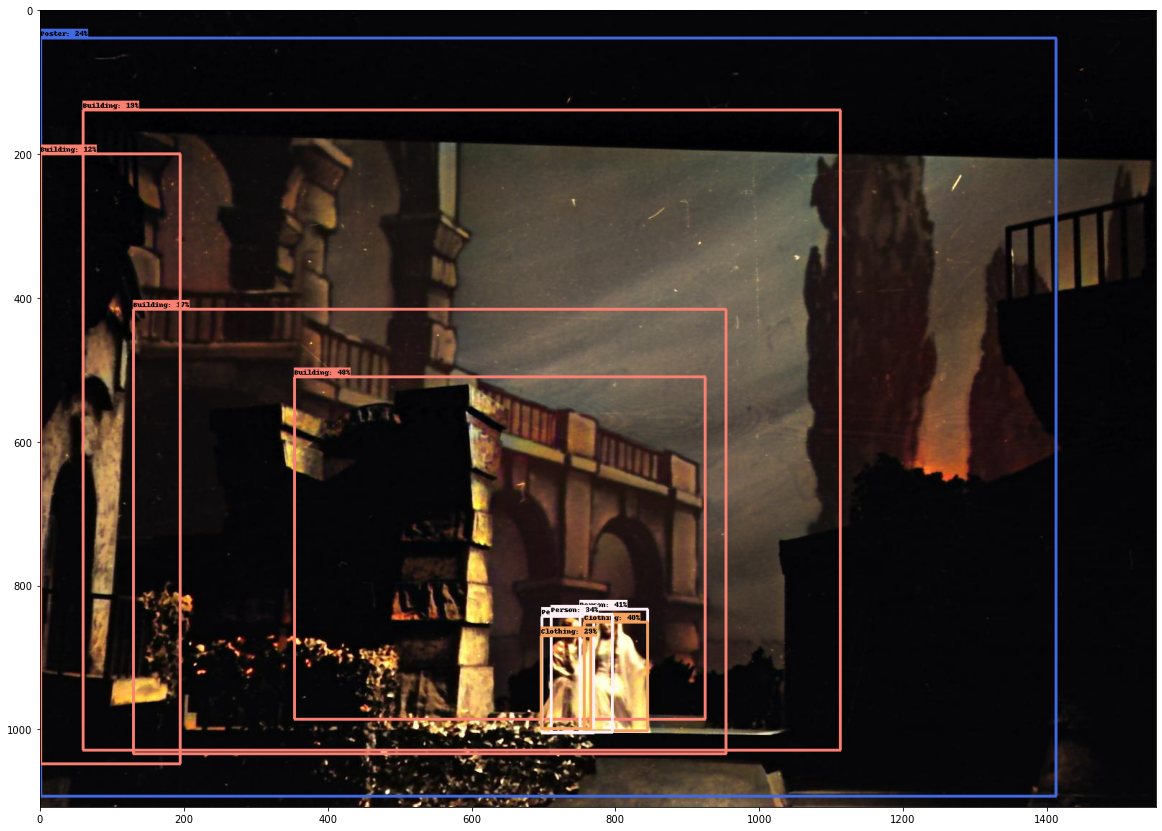

In [9]:
# Draw detections on copied image
j = 0
IMAGES_WITH_DETECTION = []
for image in IMAGES:
    IMAGES_WITH_DETECTION.append(draw_boxes(
        image.numpy(), result[j]['detection_boxes'],
        result[j]['detection_class_entities'], result[j]['detection_scores'])
    )
    if j == 0:
        display_image(IMAGES_WITH_DETECTION[0])
    j += 1

In [10]:
# Add output sub-directory named after the model that was used (if it doesn't already exist)
output_dir = 'outputs/' + model_display_name + '/'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
# Save images
i = 0
for image in IMAGES_WITH_DETECTION:
    plt.imsave(output_dir + VALID_PATHS[i] + '_' + model_display_name + '.jpg', image, format='jpg')
    i += 1